In [1]:
 import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib
matplotlib.rc('font', family='AppleGothic')
matplotlib.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Í∑∏ÎûòÌîÑ ÌãÄ Î≥ÄÍ≤Ω
plt.rcParams['axes.unicode_minus'] = False
sns.set(font_scale = 1)  
plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_columns', None)

In [2]:
import re
import string
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import ( LSTM,
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wonminjae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.dropna(how = 'any', axis =1)
train['text_len']  = train['text'].apply(lambda x : len(x.split(' ')))

In [4]:
train.head()

id                                               text  target  text_len
0   1  Our Deeds are the Reason of this #earthquake M...       1        13
1   4             Forest fire near La Ronge Sask. Canada       1         7
2   5  All residents asked to 'shelter in place' are ...       1        22
3   6  13,000 people receive #wildfires evacuation or...       1         9
4   7  Just got sent this photo from Ruby #Alaska as ...       1        17

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   text      7613 non-null   object
 2   target    7613 non-null   int64 
 3   text_len  7613 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 238.0+ KB


In [6]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ïª¨ÎüºÏùÄ: {col} ÏûÖÎãàÎã§')
            print(f'Ìï¥Îãπ Ïª¨ÎüºÏóê Ï¥ù {missing_values} Í∞úÏùò Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§')
    return missing_col

missing_col = check_missing_col(train)

Í≤∞Ï∏°ÏπòÍ∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§


In [7]:
print('ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ÏÖãÏùò {} Ìñâ Í≥º {} Ïó¥ '.format(train.shape[0],train.shape[1]))
print('ÌÖåÏä§Ìä∏Îç∞Ïù¥ÌÑ∞ÏÖãÏùò {} Ìñâ Í≥º {} Ïó¥ '.format(test.shape[0],test.shape[1]))

ÌõàÎ†®Îç∞Ïù¥ÌÑ∞ÏÖãÏùò 7613 Ìñâ Í≥º 4 Ïó¥ 
ÌÖåÏä§Ìä∏Îç∞Ïù¥ÌÑ∞ÏÖãÏùò 3263 Ìñâ Í≥º 4 Ïó¥ 


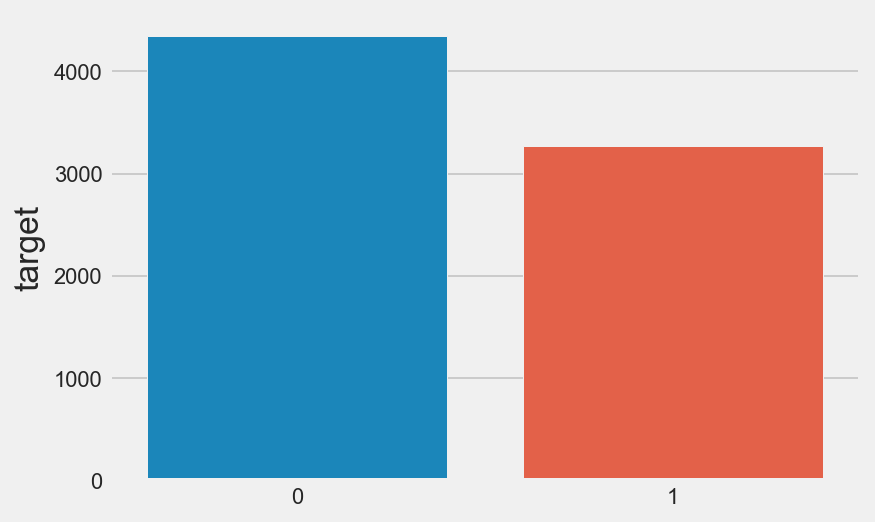

In [8]:
x = train.target.value_counts()

sns.barplot(x.index, x)
plt.show()

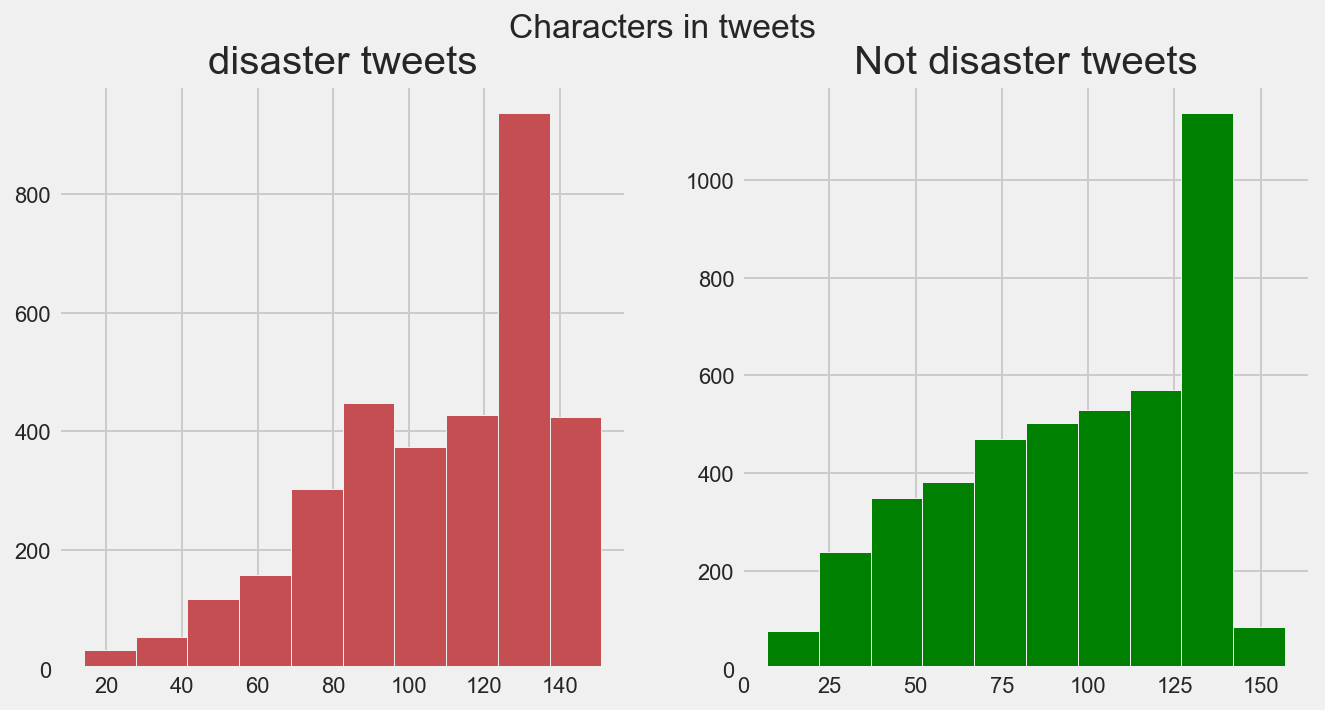

In [9]:
fig , axes = plt.subplots(1, 2, figsize = (10, 5))

t_len=train[train['target']==1]['text'].str.len()
axes[0].hist(t_len, color = 'r')
axes[0].set_title('disaster tweets')
              
t_len= train[train['target']==0]['text'].str.len()
axes[1].hist(t_len,color='green')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

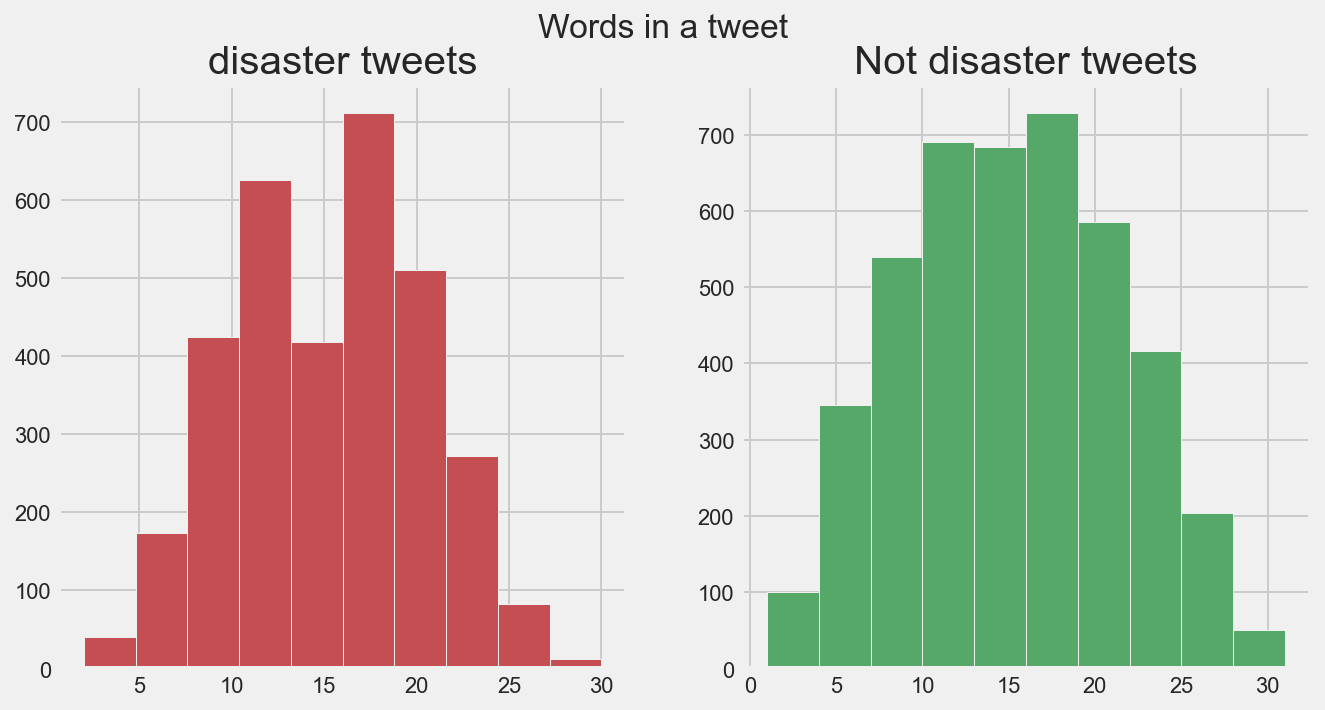

In [10]:
fig ,axes =plt.subplots(1,2 , figsize = (10, 5))

t_len = train[train['target']==1]['text'].str.split().map(lambda x : len(x))
axes[0].hist(t_len, color = 'r')
axes[0].set_title('disaster tweets')

t_len = train[train['target']==0]['text'].str.split().map(lambda x : len(x))
axes[1].hist(t_len, color = 'g')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()


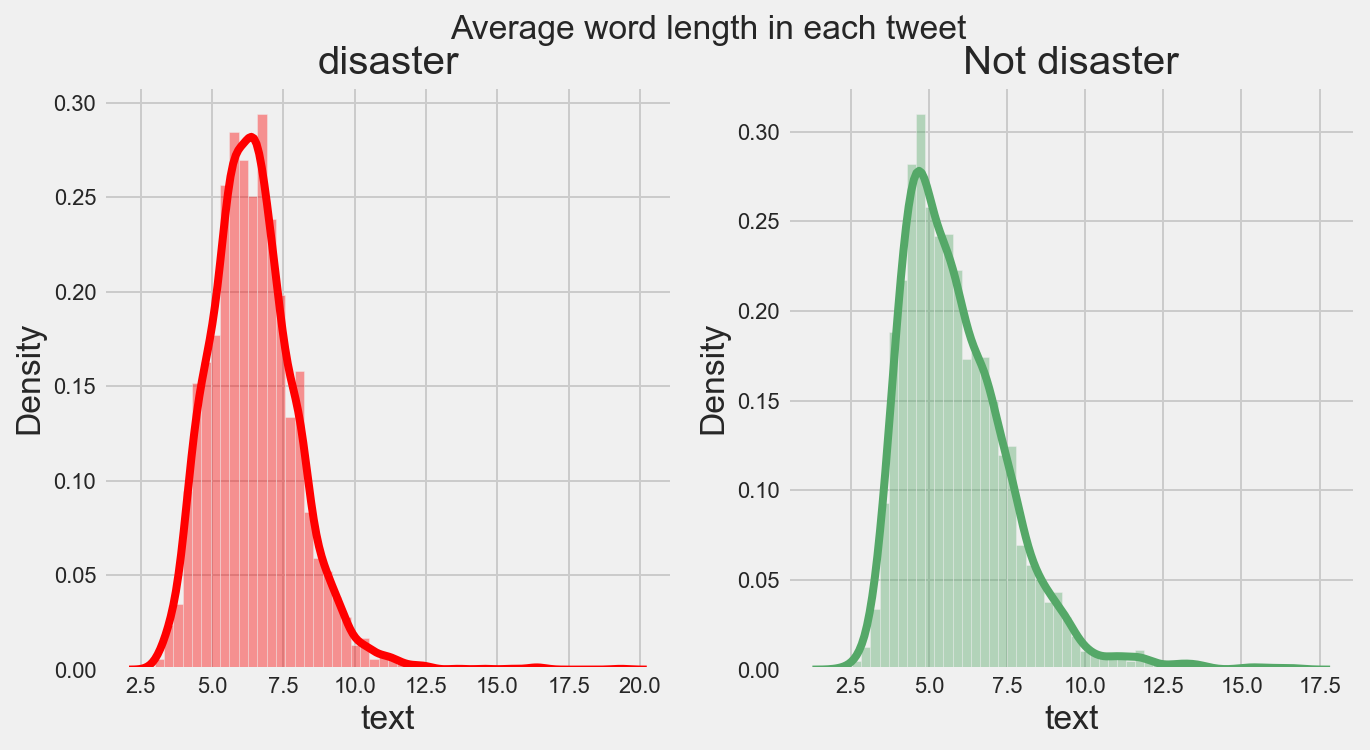

In [11]:
fig, axes = plt.subplots(1,2 , figsize = (10,5))

w = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(w.map(lambda x: np.mean(x)),ax=axes[0],color='red')
axes[0].set_title('disaster')

w = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(w.map(lambda x: np.mean(x)),ax=axes[1],color='g')
axes[1].set_title('Not disaster')
fig.suptitle('Average word length in each tweet')
plt.show()

### Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ 

In [12]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
  
def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [14]:
# test 
remove_emoji("I don't sure that  üòîüòî")

"I don't sure that  "

In [15]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords and Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text


In [16]:
test['cleaned_text'] = test['text'].apply(preprocess_data)

train['cleaned_text'] = train['text'].apply(preprocess_data)

### Î™®Îç∏ÎßÅ


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

In [19]:
train_tweets = train['cleaned_text'].values
test_tweets = test['cleaned_text'].values
train_target = train['cleaned_text'].values

In [20]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13697

In [21]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)


### PADDING

In [22]:
# Pad_sequences
nltk.download('punkt')

longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences


[nltk_data] Downloading package punkt to /Users/wonminjae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array([[3635,  467,  201, ...,    0,    0,    0],
       [ 137,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1806, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2636, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]], dtype=int32)

### GLOVE

In [23]:
embeddings_dictionary = dict()
embedding_dim = 100

with open('glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions


In [24]:
# Glove

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [27]:
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           1369700   
                                                                 
 bidirectional (Bidirectiona  (None, 23, 46)           22816     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 46)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 46)               184       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 46)                0         
                                                        

In [ ]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)


In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
preds = model.predict_classes(X_test)
show_metrics(preds, y_test)

### BERT 

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification

In [ ]:
df = pd.read_csv("../input/cola-the-corpus-of-linguistic-acceptability/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

In [ ]:
MAX_LEN = 128

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


In [ ]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [ ]:
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

In [ ]:
optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [ ]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs 
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
 # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0


In [ ]:
 # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    # batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()
